# Unsupervised Learning Trading Strategy
- Download/Load SP500 stocks prices data.
- Calculate different features and indicators on each stock.
- Aggregate on monthly level and filter top 150 most liquid stocks.
- Calculate Monthly Returns for different time-horizons.
- Download Fama-French Factors and Calculate Rolling Factor Betas.
- For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
- For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
- Visualize Portfolio returns and compare to SP500 returns.

## 1. Download/Load SP500 stocks prices data.

In [96]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xlsxwriter
import math
import yfinance as yf
import pandas_ta as ta
import datetime as dt
import warnings
from yahooquery import Ticker

warnings.filterwarnings('ignore')

In [127]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

symbols_list.remove('VLTO')

symbols_string = " ".join(str(element) for element in symbols_list)
tickers = yf.Tickers(symbols_string)

end_date = '2024-01-04'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# tickers = Ticker(symbols_string, asynchronous=True)

# Default period = ytd, interval = 1d

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df


[*********************100%%**********************]  502 of 502 completed


Adj Close       Close        High         Low        Open  \
Date                                                                          
2016-01-06 A      38.171921   40.730000   40.990002   40.049999   40.240002   
           AAL    39.401268   41.230000   41.700001   40.000000   40.049999   
           AAPL   22.919146   25.174999   25.592501   24.967501   25.139999   
           ABBV   40.615276   57.380001   57.560001   56.180000   56.369999   
           ABT    36.637783   42.560001   42.980000   42.209999   42.310001   
...                     ...         ...         ...         ...         ...   
2024-01-03 YUM   129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH   120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA  252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION   42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS   192.929993  192.929993  195.949997  192.800003  195.919998   

                      Volume  
Date                          
2016-01-06 A       2103600.0  
           AAL    12393800.0  
           AAPL  273829600.0  
           ABBV    8952700.0  
           ABT     5906000.0  
...                      ...  
2024-01-03 YUM     1483600.0  
           ZBH     2325500.0  
           ZBRA     404800.0  
           ZION    3048300.0  
           ZTS     1493000.0  

[994485 rows x 6 columns]

In [143]:
df.index.names = ['date', 'symbol']
df.columns = df.columns.str.lower()

df

adj close       close        high         low        open  \
date       symbol                                                               
2016-01-06 A        38.171921   40.730000   40.990002   40.049999   40.240002   
           AAL      39.401268   41.230000   41.700001   40.000000   40.049999   
           AAPL     22.919146   25.174999   25.592501   24.967501   25.139999   
           ABBV     40.615276   57.380001   57.560001   56.180000   56.369999   
           ABT      36.637783   42.560001   42.980000   42.209999   42.310001   
...                       ...         ...         ...         ...         ...   
2024-01-03 YUM     129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH     120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA    252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION     42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS     192.929993  192.929993  195.949997  192.800003  195.919998   

                        volume  garman_klass_vol        rsi    bb_low  \
date       symbol                                                       
2016-01-06 A         2103600.0         -0.000806        NaN       NaN   
           AAL      12393800.0          0.000763        NaN       NaN   
           AAPL    273829600.0         -0.002999        NaN       NaN   
           ABBV      8952700.0         -0.041212        NaN       NaN   
           ABT       5906000.0         -0.007841        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-03 YUM       1483600.0          0.000055  54.360388  4.828101   
           ZBH       2325500.0          0.000080  63.340087  4.755974   
           ZBRA       404800.0          0.000515  52.714502  5.428569   
           ZION      3048300.0          0.000349  56.397718  3.629474   
           ZTS       1493000.0          0.000040  58.881491  5.204421   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       symbol                                                         
2016-01-06 A            NaN       NaN       NaN       NaN      80.298453  
           AAL          NaN       NaN       NaN       NaN     488.331435  
           AAPL         NaN       NaN       NaN       NaN    6275.940468  
           ABBV         NaN       NaN       NaN       NaN     363.616384  
           ABT          NaN       NaN       NaN       NaN     216.382747  
...                     ...       ...       ...       ...            ...  
2024-01-03 YUM     4.864795  4.901488 -0.079818  0.574398     191.532769  
           ZBH     4.787581  4.819187 -1.050234  0.886119     280.152988  
           ZBRA    5.554209  5.679848  0.006201  1.213089     102.220098  
           ZION    3.760402  3.891330  0.300673  1.757465     128.028600  
           ZTS     5.266937  5.329454  0.420384  1.808639     288.044479  

[994485 rows x 14 columns]

## 2. Calculate features and technical indicators for each stock.

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

In [144]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df

adj close       close        high         low        open  \
date       symbol                                                               
2016-01-06 A        38.171921   40.730000   40.990002   40.049999   40.240002   
           AAL      39.401268   41.230000   41.700001   40.000000   40.049999   
           AAPL     22.919146   25.174999   25.592501   24.967501   25.139999   
           ABBV     40.615276   57.380001   57.560001   56.180000   56.369999   
           ABT      36.637783   42.560001   42.980000   42.209999   42.310001   
...                       ...         ...         ...         ...         ...   
2024-01-03 YUM     129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH     120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA    252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION     42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS     192.929993  192.929993  195.949997  192.800003  195.919998   

                        volume  garman_klass_vol        rsi    bb_low  \
date       symbol                                                       
2016-01-06 A         2103600.0         -0.000806        NaN       NaN   
           AAL      12393800.0          0.000763        NaN       NaN   
           AAPL    273829600.0         -0.002999        NaN       NaN   
           ABBV      8952700.0         -0.041212        NaN       NaN   
           ABT       5906000.0         -0.007841        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-03 YUM       1483600.0          0.000055  54.360388  4.828101   
           ZBH       2325500.0          0.000080  63.340087  4.755974   
           ZBRA       404800.0          0.000515  52.714502  5.428569   
           ZION      3048300.0          0.000349  56.397718  3.629474   
           ZTS       1493000.0          0.000040  58.881491  5.204421   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       symbol                                                         
2016-01-06 A            NaN       NaN       NaN       NaN      80.298453  
           AAL          NaN       NaN       NaN       NaN     488.331435  
           AAPL         NaN       NaN       NaN       NaN    6275.940468  
           ABBV         NaN       NaN       NaN       NaN     363.616384  
           ABT          NaN       NaN       NaN       NaN     216.382747  
...                     ...       ...       ...       ...            ...  
2024-01-03 YUM     4.864795  4.901488 -0.079818  0.574398     191.532769  
           ZBH     4.787581  4.819187 -1.050234  0.886119     280.152988  
           ZBRA    5.554209  5.679848  0.006201  1.213089     102.220098  
           ZION    3.760402  3.891330  0.300673  1.757465     128.028600  
           ZTS     5.266937  5.329454  0.420384  1.808639     288.044479  

[994485 rows x 14 columns]

<Axes: xlabel='date'>

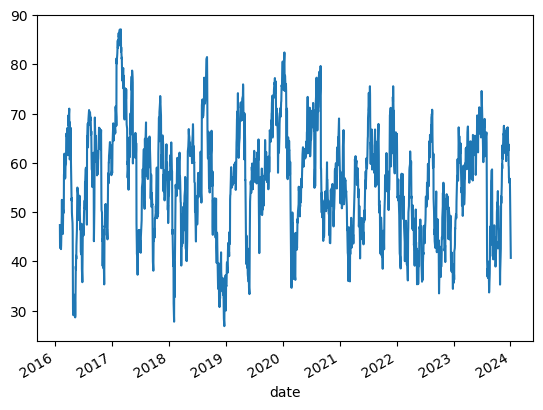

In [145]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.rsi(close=x, length = 20))

df.xs('AAPL', level=1)['rsi'].plot()

In [146]:
df = df.groupby(level='symbol').filter(lambda x: len(x) >= 20)

In [147]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

In [148]:
df

adj close       close        high         low        open  \
date       symbol                                                               
2016-01-06 A        38.171921   40.730000   40.990002   40.049999   40.240002   
           AAL      39.401268   41.230000   41.700001   40.000000   40.049999   
           AAPL     22.919146   25.174999   25.592501   24.967501   25.139999   
           ABBV     40.615276   57.380001   57.560001   56.180000   56.369999   
           ABT      36.637783   42.560001   42.980000   42.209999   42.310001   
...                       ...         ...         ...         ...         ...   
2024-01-03 YUM     129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH     120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA    252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION     42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS     192.929993  192.929993  195.949997  192.800003  195.919998   

                        volume  garman_klass_vol        rsi    bb_low  \
date       symbol                                                       
2016-01-06 A         2103600.0         -0.000806        NaN       NaN   
           AAL      12393800.0          0.000763        NaN       NaN   
           AAPL    273829600.0         -0.002999        NaN       NaN   
           ABBV      8952700.0         -0.041212        NaN       NaN   
           ABT       5906000.0         -0.007841        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-03 YUM       1483600.0          0.000055  54.360388  4.828101   
           ZBH       2325500.0          0.000080  63.340087  4.755974   
           ZBRA       404800.0          0.000515  52.714502  5.428569   
           ZION      3048300.0          0.000349  56.397718  3.629474   
           ZTS       1493000.0          0.000040  58.881491  5.204421   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       symbol                                                         
2016-01-06 A            NaN       NaN       NaN       NaN      80.298453  
           AAL          NaN       NaN       NaN       NaN     488.331435  
           AAPL         NaN       NaN       NaN       NaN    6275.940468  
           ABBV         NaN       NaN       NaN       NaN     363.616384  
           ABT          NaN       NaN       NaN       NaN     216.382747  
...                     ...       ...       ...       ...            ...  
2024-01-03 YUM     4.864795  4.901488 -0.079818  0.574398     191.532769  
           ZBH     4.787581  4.819187 -1.050234  0.886119     280.152988  
           ZBRA    5.554209  5.679848  0.006201  1.213089     102.220098  
           ZION    3.760402  3.891330  0.300673  1.757465     128.028600  
           ZTS     5.266937  5.329454  0.420384  1.808639     288.044479  

[994485 rows x 14 columns]

In [149]:
ta.atr(high=df['high'], low=df['low'],close=df['close'],length=14)

date        symbol
2016-01-06  A                NaN
            AAL              NaN
            AAPL             NaN
            ABBV             NaN
            ABT              NaN
                         ...    
2024-01-03  YUM        98.963353
            ZBH        92.564542
            ZBRA       96.315645
            ZION      104.483099
            ZTS       108.016449
Name: ATRr_14, Length: 994485, dtype: float64

In [150]:
def compute_atr(stock_data):
    atr = ta.atr(high=stock_data['high'], low=stock_data['low'],close=stock_data['close'],length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

In [151]:
df

adj close       close        high         low        open  \
date       symbol                                                               
2016-01-06 A        38.171921   40.730000   40.990002   40.049999   40.240002   
           AAL      39.401268   41.230000   41.700001   40.000000   40.049999   
           AAPL     22.919146   25.174999   25.592501   24.967501   25.139999   
           ABBV     40.615276   57.380001   57.560001   56.180000   56.369999   
           ABT      36.637783   42.560001   42.980000   42.209999   42.310001   
...                       ...         ...         ...         ...         ...   
2024-01-03 YUM     129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH     120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA    252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION     42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS     192.929993  192.929993  195.949997  192.800003  195.919998   

                        volume  garman_klass_vol        rsi    bb_low  \
date       symbol                                                       
2016-01-06 A         2103600.0         -0.000806        NaN       NaN   
           AAL      12393800.0          0.000763        NaN       NaN   
           AAPL    273829600.0         -0.002999        NaN       NaN   
           ABBV      8952700.0         -0.041212        NaN       NaN   
           ABT       5906000.0         -0.007841        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-03 YUM       1483600.0          0.000055  54.360388  4.828101   
           ZBH       2325500.0          0.000080  63.340087  4.755974   
           ZBRA       404800.0          0.000515  52.714502  5.428569   
           ZION      3048300.0          0.000349  56.397718  3.629474   
           ZTS       1493000.0          0.000040  58.881491  5.204421   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       symbol                                                         
2016-01-06 A            NaN       NaN       NaN       NaN      80.298453  
           AAL          NaN       NaN       NaN       NaN     488.331435  
           AAPL         NaN       NaN       NaN       NaN    6275.940468  
           ABBV         NaN       NaN       NaN       NaN     363.616384  
           ABT          NaN       NaN       NaN       NaN     216.382747  
...                     ...       ...       ...       ...            ...  
2024-01-03 YUM     4.864795  4.901488 -0.079818  0.574398     191.532769  
           ZBH     4.787581  4.819187 -1.050234  0.886119     280.152988  
           ZBRA    5.554209  5.679848  0.006201  1.213089     102.220098  
           ZION    3.760402  3.891330  0.300673  1.757465     128.028600  
           ZTS     5.266937  5.329454  0.420384  1.808639     288.044479  

[994485 rows x 14 columns]

In [152]:
def compute_macd(close):
    macd = ta.macd(close=close, length = 20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df

adj close       close        high         low        open  \
date       symbol                                                               
2016-01-06 A        38.171921   40.730000   40.990002   40.049999   40.240002   
           AAL      39.401268   41.230000   41.700001   40.000000   40.049999   
           AAPL     22.919146   25.174999   25.592501   24.967501   25.139999   
           ABBV     40.615276   57.380001   57.560001   56.180000   56.369999   
           ABT      36.637783   42.560001   42.980000   42.209999   42.310001   
...                       ...         ...         ...         ...         ...   
2024-01-03 YUM     129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH     120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA    252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION     42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS     192.929993  192.929993  195.949997  192.800003  195.919998   

                        volume  garman_klass_vol        rsi    bb_low  \
date       symbol                                                       
2016-01-06 A         2103600.0         -0.000806        NaN       NaN   
           AAL      12393800.0          0.000763        NaN       NaN   
           AAPL    273829600.0         -0.002999        NaN       NaN   
           ABBV      8952700.0         -0.041212        NaN       NaN   
           ABT       5906000.0         -0.007841        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-03 YUM       1483600.0          0.000055  54.360388  4.828101   
           ZBH       2325500.0          0.000080  63.340087  4.755974   
           ZBRA       404800.0          0.000515  52.714502  5.428569   
           ZION      3048300.0          0.000349  56.397718  3.629474   
           ZTS       1493000.0          0.000040  58.881491  5.204421   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       symbol                                                         
2016-01-06 A            NaN       NaN       NaN       NaN      80.298453  
           AAL          NaN       NaN       NaN       NaN     488.331435  
           AAPL         NaN       NaN       NaN       NaN    6275.940468  
           ABBV         NaN       NaN       NaN       NaN     363.616384  
           ABT          NaN       NaN       NaN       NaN     216.382747  
...                     ...       ...       ...       ...            ...  
2024-01-03 YUM     4.864795  4.901488 -0.079818  0.574398     191.532769  
           ZBH     4.787581  4.819187 -1.050234  0.886119     280.152988  
           ZBRA    5.554209  5.679848  0.006201  1.213089     102.220098  
           ZION    3.760402  3.891330  0.300673  1.757465     128.028600  
           ZTS     5.266937  5.329454  0.420384  1.808639     288.044479  

[994485 rows x 14 columns]

In [153]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

adj close       close        high         low        open  \
date       symbol                                                               
2016-01-06 A        38.171921   40.730000   40.990002   40.049999   40.240002   
           AAL      39.401268   41.230000   41.700001   40.000000   40.049999   
           AAPL     22.919146   25.174999   25.592501   24.967501   25.139999   
           ABBV     40.615276   57.380001   57.560001   56.180000   56.369999   
           ABT      36.637783   42.560001   42.980000   42.209999   42.310001   
...                       ...         ...         ...         ...         ...   
2024-01-03 YUM     129.100006  129.100006  130.539993  128.940002  130.059998   
           ZBH     120.470001  120.470001  121.300003  119.720001  120.930000   
           ZBRA    252.520004  252.520004  265.549988  252.380005  264.119995   
           ZION     42.000000   42.000000   43.439999   41.860001   43.259998   
           ZTS     192.929993  192.929993  195.949997  192.800003  195.919998   

                        volume  garman_klass_vol        rsi    bb_low  \
date       symbol                                                       
2016-01-06 A         2103600.0         -0.000806        NaN       NaN   
           AAL      12393800.0          0.000763        NaN       NaN   
           AAPL    273829600.0         -0.002999        NaN       NaN   
           ABBV      8952700.0         -0.041212        NaN       NaN   
           ABT       5906000.0         -0.007841        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-03 YUM       1483600.0          0.000055  54.360388  4.828101   
           ZBH       2325500.0          0.000080  63.340087  4.755974   
           ZBRA       404800.0          0.000515  52.714502  5.428569   
           ZION      3048300.0          0.000349  56.397718  3.629474   
           ZTS       1493000.0          0.000040  58.881491  5.204421   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       symbol                                                         
2016-01-06 A            NaN       NaN       NaN       NaN      80.298453  
           AAL          NaN       NaN       NaN       NaN     488.331435  
           AAPL         NaN       NaN       NaN       NaN    6275.940468  
           ABBV         NaN       NaN       NaN       NaN     363.616384  
           ABT          NaN       NaN       NaN       NaN     216.382747  
...                     ...       ...       ...       ...            ...  
2024-01-03 YUM     4.864795  4.901488 -0.079818  0.574398     191.532769  
           ZBH     4.787581  4.819187 -1.050234  0.886119     280.152988  
           ZBRA    5.554209  5.679848  0.006201  1.213089     102.220098  
           ZION    3.760402  3.891330  0.300673  1.757465     128.028600  
           ZTS     5.266937  5.329454  0.420384  1.808639     288.044479  

[994485 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [168]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
last_cols

['adj close',
 'garman_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'atr',
 'macd']

In [196]:
data=pd.concat([df.unstack('symbol')['dollar_volume'].resample('M').mean().stack('symbol').to_frame('dollar_volume'),
         df.unstack()[last_cols].resample('M').last().stack('symbol')], axis=1).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       symbol                                                           
2016-02-29 A           91.918051   35.004211         -0.001913  48.056854   
           AAL        338.977808   39.288380         -0.000319  56.535115   
           AAPL      3548.073808   22.125887         -0.003013  49.871951   
           ABBV       357.006457   39.060581         -0.049101  47.996254   
           ABT        245.865712   33.559795         -0.009363  47.314174   
...                          ...         ...               ...        ...   
2024-01-31 YUM        191.590513  129.100006          0.000055  54.360388   
           ZBH        206.076237  120.470001          0.000080  63.340087   
           ZBRA       111.794122  252.520004          0.000515  52.714502   
           ZION       113.819668   42.000000          0.000349  56.397718   
           ZTS        305.435701  192.929993          0.000040  58.881491   

                     bb_low    bb_mid   bb_high       atr      macd  
date       symbol                                                    
2016-02-29 A       3.522492  3.571307  3.620122 -0.932254 -0.223693  
           AAL     3.547833  3.638645  3.729458  0.974628  0.507460  
           AAPL    3.106253  3.130723  3.155194 -1.020407 -0.318753  
           ABBV    3.638599  3.686634  3.734669 -0.472983 -0.317716  
           ABT     3.483742  3.527338  3.570934 -0.794542 -0.387868  
...                     ...       ...       ...       ...       ...  
2024-01-31 YUM     4.828101  4.864795  4.901488 -0.079818  0.574398  
           ZBH     4.755974  4.787581  4.819187 -1.050234  0.886119  
           ZBRA    5.428569  5.554209  5.679848  0.006201  1.213089  
           ZION    3.629474  3.760402  3.891330  0.300673  1.757465  
           ZTS     5.204421  5.266937  5.329454  0.420384  1.808639  

[47453 rows x 9 columns]

Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [197]:
data['dollar_volume'] = data['dollar_volume'].unstack('symbol').rolling(5*12-1).mean().stack()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       symbol                                                           
2016-02-29 A                 NaN   35.004211         -0.001913  48.056854   
           AAL               NaN   39.288380         -0.000319  56.535115   
           AAPL              NaN   22.125887         -0.003013  49.871951   
           ABBV              NaN   39.060581         -0.049101  47.996254   
           ABT               NaN   33.559795         -0.009363  47.314174   
...                          ...         ...               ...        ...   
2024-01-31 YUM        187.530398  129.100006          0.000055  54.360388   
           ZBH        174.903143  120.470001          0.000080  63.340087   
           ZBRA       126.050132  252.520004          0.000515  52.714502   
           ZION        87.262711   42.000000          0.000349  56.397718   
           ZTS        306.917501  192.929993          0.000040  58.881491   

                     bb_low    bb_mid   bb_high       atr      macd  
date       symbol                                                    
2016-02-29 A       3.522492  3.571307  3.620122 -0.932254 -0.223693  
           AAL     3.547833  3.638645  3.729458  0.974628  0.507460  
           AAPL    3.106253  3.130723  3.155194 -1.020407 -0.318753  
           ABBV    3.638599  3.686634  3.734669 -0.472983 -0.317716  
           ABT     3.483742  3.527338  3.570934 -0.794542 -0.387868  
...                     ...       ...       ...       ...       ...  
2024-01-31 YUM     4.828101  4.864795  4.901488 -0.079818  0.574398  
           ZBH     4.755974  4.787581  4.819187 -1.050234  0.886119  
           ZBRA    5.428569  5.554209  5.679848  0.006201  1.213089  
           ZION    3.629474  3.760402  3.891330  0.300673  1.757465  
           ZTS     5.204421  5.266937  5.329454  0.420384  1.808639  

[47453 rows x 9 columns]

In [198]:
data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       symbol                                                           
2016-02-29 A                 NaN   35.004211         -0.001913  48.056854   
           AAL               NaN   39.288380         -0.000319  56.535115   
           AAPL              NaN   22.125887         -0.003013  49.871951   
           ABBV              NaN   39.060581         -0.049101  47.996254   
           ABT               NaN   33.559795         -0.009363  47.314174   
...                          ...         ...               ...        ...   
2024-01-31 YUM        187.530398  129.100006          0.000055  54.360388   
           ZBH        174.903143  120.470001          0.000080  63.340087   
           ZBRA       126.050132  252.520004          0.000515  52.714502   
           ZION        87.262711   42.000000          0.000349  56.397718   
           ZTS        306.917501  192.929993          0.000040  58.881491   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       symbol                                                     
2016-02-29 A       3.522492  3.571307  3.620122 -0.932254 -0.223693   
           AAL     3.547833  3.638645  3.729458  0.974628  0.507460   
           AAPL    3.106253  3.130723  3.155194 -1.020407 -0.318753   
           ABBV    3.638599  3.686634  3.734669 -0.472983 -0.317716   
           ABT     3.483742  3.527338  3.570934 -0.794542 -0.387868   
...                     ...       ...       ...       ...       ...   
2024-01-31 YUM     4.828101  4.864795  4.901488 -0.079818  0.574398   
           ZBH     4.755974  4.787581  4.819187 -1.050234  0.886119   
           ZBRA    5.428569  5.554209  5.679848  0.006201  1.213089   
           ZION    3.629474  3.760402  3.891330  0.300673  1.757465   
           ZTS     5.204421  5.266937  5.329454  0.420384  1.808639   

                   dollar_vol_rank  
date       symbol                   
2016-02-29 A                   NaN  
           AAL                 NaN  
           AAPL                NaN  
           ABBV                NaN  
           ABT                 NaN  
...                            ...  
2024-01-31 YUM               256.0  
           ZBH               273.0  
           ZBRA              350.0  
           ZION              439.0  
           ZTS               152.0  

[47453 rows x 10 columns]

In [200]:
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
data

adj close  garman_klass_vol        rsi    bb_low  \
date       symbol                                                      
2020-12-31 AAL      15.770000          0.000274  53.851312  2.786625   
           AAPL    130.387222         -0.000044  61.780755  4.767201   
           ABBV     94.590317         -0.004150  63.817808  4.508703   
           ABT     103.964111         -0.000472  53.978328  4.622379   
           ACN     250.567093         -0.000186  61.643818  5.447041   
...                       ...               ...        ...       ...   
2024-01-31 VRTX    410.709991          0.000113  67.267742  5.842299   
           VZ       39.160000          0.000078  66.850159  3.628841   
           WFC      48.680000          0.000098  63.184585  3.816344   
           WMT     159.300003          0.000033  55.532537  5.015848   
           XOM     103.220001          0.000149  51.511383  4.593886   

                     bb_mid   bb_high       atr      macd  
date       symbol                                          
2020-12-31 AAL     2.862562  2.938499 -0.612985  0.589417  
           AAPL    4.839685  4.912170  0.761202  1.605560  
           ABBV    4.541142  4.573580 -0.195120  0.483334  
           ABT     4.637641  4.652903  0.301392 -0.191014  
           ACN     5.499891  5.552741  0.267611  0.915936  
...                     ...       ...       ...       ...  
2024-01-31 VRTX    5.968725  6.095150  1.055460  3.141795  
           VZ      3.658951  3.689060 -0.907484  0.827693  
           WFC     3.896063  3.975782 -0.702193  1.652083  
           WMT     5.048842  5.081837 -0.022442  0.067748  
           XOM     4.622754  4.651621  0.220312 -0.402836  

[5662 rows x 8 columns]

In [ ]:
4. Calculate Monthly Returns for different time horizons as features.

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.